<a href="https://colab.research.google.com/github/jingairpi/llm.jax/blob/main/notebooks/llm.jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/jingairpi/llm.jax.git

%cd llm.jax
!pip install -e .

!pip install tiktoken

fatal: destination path 'llm.jax' already exists and is not an empty directory.
/content/llm.jax
Obtaining file:///content/llm.jax
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for llm-jax (pyproject.toml) ... done
  Created wheel for llm-jax: filename=llm_jax-0.1.0-py3-none-any.whl size=2007 sha256=b30aab5f144b1bab80988fe4047758caa2351d8ea93c94ae056b006163b2a96b
  Stored in directory: /tmp/pip-ephem-wheel-cache-6kia6k4v/wheels/f5/45/9b/9974346d34cbb3b99a739447c080dfbe67d48b90c92e1b3961
Successfully built llm-jax
  Attempting uninstall: llm-jax
    Found existing installation: llm-jax 0.1.0
    Uninstalling llm-jax-0.1.0:
      Successfully uninstalled llm-jax-0.1.0


In [2]:
import requests
import numpy as np
import tiktoken

# Download Tiny Shakespeare.
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text

# Get GPT-2 encoding.
enc = tiktoken.get_encoding("gpt2")

# Encode the text into token IDs.
tokens = enc.encode(text)
tokens = np.array(tokens, dtype=np.int32)

# Save tokens to a binary file.
with open("tiny_shakespeare.bin", "wb") as f:
    tokens.tofile(f)

print(f"Saved {len(tokens)} tokens to tiny_shakespeare.bin")

Saved 338025 tokens to tiny_shakespeare.bin


Starting training for 25 epochs...
Epoch 1 starting...
Epoch 1 complete. Average Training Loss: 10.2554, Eval Loss: 9.7765
Epoch 2 starting...
Epoch 2 complete. Average Training Loss: 9.4167, Eval Loss: 8.9801
Epoch 3 starting...
Epoch 3 complete. Average Training Loss: 8.6622, Eval Loss: 8.2845
Epoch 4 starting...
Epoch 4 complete. Average Training Loss: 8.0231, Eval Loss: 7.7090
Epoch 5 starting...
Epoch 5 complete. Average Training Loss: 7.5069, Eval Loss: 7.2535
Epoch 6 starting...
Epoch 6 complete. Average Training Loss: 7.1074, Eval Loss: 6.9075
Epoch 7 starting...
Epoch 7 complete. Average Training Loss: 6.8105, Eval Loss: 6.6539
Epoch 8 starting...
Epoch 8 complete. Average Training Loss: 6.5975, Eval Loss: 6.4731
Epoch 9 starting...
Epoch 9 complete. Average Training Loss: 6.4480, Eval Loss: 6.3447
Epoch 10 starting...
Epoch 10 complete. Average Training Loss: 6.3361, Eval Loss: 6.2414
Epoch 11 starting...
Epoch 11 complete. Average Training Loss: 6.2382, Eval Loss: 6.1460
Epo

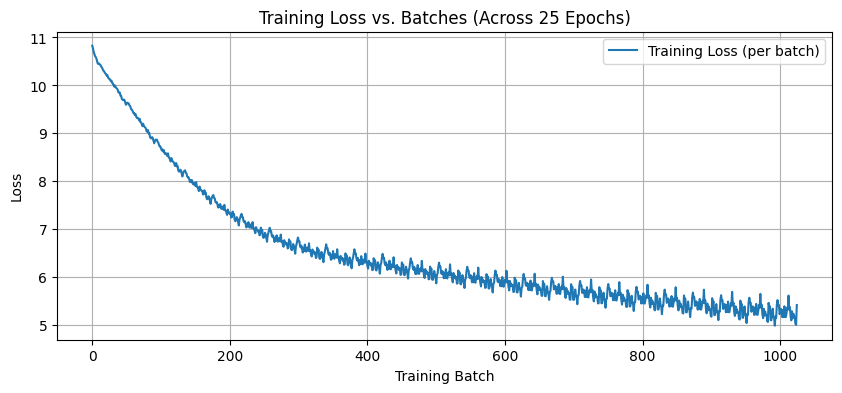

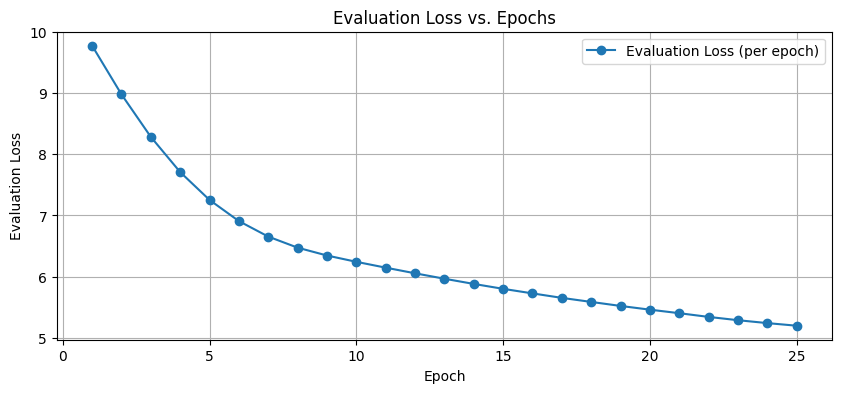

In [3]:
import jax
import jax.numpy as jnp
import tiktoken
import matplotlib.pyplot as plt

from llm.config import GPT2Config
from llm.data import DataLoader
from llm.model import GPT2Model
from llm.trainer import Trainer
from llm.evaluator import Evaluator

# -----------------------------------------------------------------------------
# Define a smaller GPT-2 model configuration (for resource constraints)
config = GPT2Config(
    vocab_size=50257,  # Standard GPT-2 vocabulary size
    n_positions=256,   # Use a shorter sequence length for training and inference
    n_embd=128,        # Smaller embedding dimension
    n_layer=2,         # Two transformer blocks
    n_head=2,          # Two attention heads
)

# Instantiate the model.
model = GPT2Model(config)

# Define optimizer configuration.
optimizer_config = {
    "learning_rate": 1e-4,
    "batch_size": 32,  # Adjust based on your available GPU memory
}

# Use a sequence length that matches your model's n_positions.
seq_len = 256

# Create a DataLoader instance for training with repeat disabled (i.e. one full epoch).
train_loader = DataLoader("tiny_shakespeare.bin", optimizer_config["batch_size"], seq_len, repeat=False)

# Create a separate DataLoader for evaluation (repeat disabled).
eval_loader = DataLoader("tiny_shakespeare.bin", optimizer_config["batch_size"], seq_len, repeat=False)

# Create a random number generator key.
rng = jax.random.PRNGKey(0)

# Instantiate your Trainer.
trainer = Trainer(model, config, optimizer_config, train_loader, rng)

# Instantiate Evaluator.
evaluator = Evaluator(model, eval_loader)

# -----------------------------------------------------------------------------
# Epoch-aware Training: Train for 25 epochs.
num_epochs = 25
all_training_losses = []  # To record training loss per batch across all epochs.
epoch_eval_losses = []    # To record evaluation loss at the end of each epoch.

print("Starting training for 25 epochs...")
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1} starting...")
    epoch_losses = []  # Losses for the current epoch.

    # Iterate over the training data for one epoch.
    for batch in train_loader:
        trainer.rng, step_rng = jax.random.split(trainer.rng)
        trainer.state, loss, logits = trainer.train_step(trainer.state, batch, step_rng)
        loss_val = float(loss)
        epoch_losses.append(loss_val)
        all_training_losses.append(loss_val)

    # Evaluate at the end of the epoch (using, e.g., 5 evaluation steps).
    eval_loss = evaluator.evaluate(trainer.state.params, num_steps=5)
    epoch_eval_losses.append(eval_loss)
    print(f"Epoch {epoch + 1} complete. Average Training Loss: {sum(epoch_losses)/len(epoch_losses):.4f}, Eval Loss: {eval_loss:.4f}")

    # Reset the training DataLoader for the next epoch.
    train_loader.reset()

print("Training complete.")

# -----------------------------------------------------------------------------
# Plot the training loss per batch.
plt.figure(figsize=(10, 4))
plt.plot(all_training_losses, label="Training Loss (per batch)")
plt.xlabel("Training Batch")
plt.ylabel("Loss")
plt.title("Training Loss vs. Batches (Across 25 Epochs)")
plt.legend()
plt.grid(True)
plt.show()

# Plot the evaluation loss per epoch.
plt.figure(figsize=(10, 4))
plt.plot(range(1, num_epochs + 1), epoch_eval_losses, 'o-', label="Evaluation Loss (per epoch)")
plt.xlabel("Epoch")
plt.ylabel("Evaluation Loss")
plt.title("Evaluation Loss vs. Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [4]:
from llm.inferencer import Inferencer

# -----------------------------------------------------------------------------
# Inference: Generate text using the trained model.
inferencer = Inferencer(model, config)

# Use tiktoken to encode an input prompt.
enc = tiktoken.get_encoding("gpt2")
prompt_text = "what is the meaning of life?"
prompt_ids = enc.encode(prompt_text)
# Convert the prompt into a 2D JAX array (batch_size = 1).
initial_prompt = jnp.array([prompt_ids], dtype=jnp.int32)

# Generate additional tokens (e.g., 32 new tokens).
generated_ids = inferencer.generate(trainer.state.params, initial_prompt, max_new_tokens=32, temperature=1.0, top_k=40, rng_key=trainer.rng)
# Decode the entire sequence (prompt + generated tokens).
generated_tokens = generated_ids[0].tolist()
decoded_text = enc.decode(generated_tokens)

print("Prompt:", prompt_text)
print("Generated text:", decoded_text)

Prompt: what is the meaning of life?
Generated text: what is the meaning of life?

F
I'll you not make you be it have, and this king; is the heart?

And be well



What
